In [1628]:
import math
import numpy as np
from scipy.sparse import coo_matrix
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [1629]:
alphas_77 = np.load("./hs_tomography/alphas_77.npy")
alphas_195 = np.load("./hs_tomography/alphas_195.npy")

In [1630]:
def construct_X_not_vectorized(M, alphas, Np = None):
    # Np = Np if Np else math.ceil(math.sqrt(2) * M)
    No = alphas.shape[0]    # Number of orientations
    N =  No * Np            # flattened array length of intensitie measurements
    D = M * M               # flattened array length of tomogram
    X = np.empty((N, D), dtype=np.float32)

    
    # non-vectorized solution
    # 1. go trough each angle
    for io in range(No):

        # 2. go trough each pixel of the tomogram 
        for j in range(M*M):
            # 3. calculate where the ray going trough the center of pixel j will hit the sensors
            ja = j % M
            jb = (j - ja) / M

            # calculate length from pixel to central pixel
            center_ja = math.floor(M / 2)
            center_jb = math.floor(M / 2)

            distance = math.sqrt((ja - center_ja)**2 + (jb - center_jb)**2)

            # use sinus to compute distance of projection from center

            c_length = distance

            # Summe der winkel im Dreieck ist 180
            alpha_angle = alphas[io]
            gamma_angle = 90
            beta_angle = 180 - gamma_angle - abs(alpha_angle)

            # sinus-satz
            b_length = (math.sin(beta_angle) / math.sin(gamma_angle)) * c_length

            center_sensor = math.floor(Np / 2)
            intercept = center_sensor + b_length

            sensor_1 = math.floor(intercept)
            sensor_2 = math.ceil(intercept)

            sensor_2_weight = intercept - sensor_1
            sensor_1_weight = 1 - sensor_2_weight

            # 4. store the intensity ratio which the ray has on the two neighboring sensors in X

            ip1 = sensor_1
            ip2 = sensor_2

            i1 = ip1 + Np * io
            i2 = ip2 + Np * io

            X[i1,j] = sensor_1_weight
            X[i2,j] = sensor_2_weight
    return X

In [1631]:
def construct_X(M, alphas, Np = None, alpha_offset=0):
    Np = Np if Np else math.ceil(math.sqrt(2) * M)
    No = alphas.shape[0]    # Number of orientations
    N =  No * Np            # flattened array length of intensitie measurements
    D = M * M               # flattened array length of tomogram

    ja = np.mgrid[0:D] % M
    jb = (np.mgrid[0:D] - ja) / M

    C = np.array([ja, jb])
    C_moved = C - np.array([[M / 2],[M / 2]])
    C_moved = C_moved + np.array([[0],[0]])

    all_weights = []
    all_i_indices = []
    all_j_indices = []

    for io in range(No):

        alpha = alphas[io] + alpha_offset
        ### SOMETHING IS WRONG WITH THE PROJECTION
        n = np.array([[math.cos(alpha)], [-math.sin(alpha)]])
        p = np.dot(n.T, C_moved) 

        p = p[0]
        p = p + Np / 2

        idx_sensor1 = np.floor(p) + Np * io
        idx_sensor2 = np.ceil(p) + Np * io

        weight2 = p - np.floor(p)
        weight1 = 1 - weight2

        idx_pixel1 = np.mgrid[0:D]
        idx_pixel2 = np.mgrid[0:D]

        weights = np.append(weight1, weight2)
        idx_sensor = np.append(idx_sensor1, idx_sensor2)
        idx_pixel = np.append(idx_pixel1, idx_pixel2)

        all_weights.extend(weights)
        all_j_indices.extend(idx_pixel)
        all_i_indices.extend(idx_sensor)


    all_weights = np.array(all_weights)
    all_i_indices = np.array(all_i_indices)
    all_j_indices = np.array(all_j_indices)

    X = coo_matrix((all_weights, (all_i_indices, all_j_indices)), shape=(N, D), dtype = np.float32)
    return X

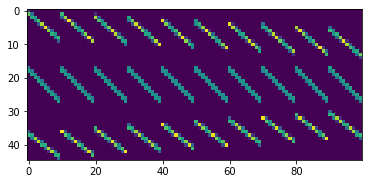

In [1632]:
X_example = np.load("./hs_tomography/X_example.npy")
plt.imshow(X_example)

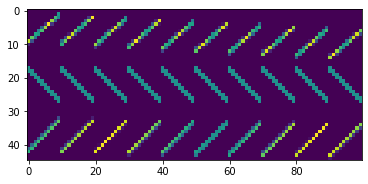

In [1636]:
#X = construct_X(M=195, alphas=alphas_195, Np=275)
X = construct_X(M=10, alphas=np.array([-33, 1, 42]), Np=15, alpha_offset=-1)
plt.imshow(X.todense())

In [1634]:
y = np.load("hs_tomography/y_195.npy", allow_pickle=True)
alphas = np.load("hs_tomography/alphas_195.npy", allow_pickle=True)

beta, solution, *_ = scipy.sparse.linalg.lsqr(X, y, atol=1e-3, btol=1e-3)

#assert solution == 1
img = beta.reshape((195, 195))
plt.imshow(img)
plt.show()

ValueError: dimension mismatch